In [1]:
# 共通事前処理

# 余分な Warning を非常にする
import warnings

warnings.filterwarnings('ignore')

# Library の import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Originals
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

# matplotlib 日本語化対応
import japanize_matplotlib

# DataFrame 表示用関数
from IPython.display import display

# 表示 Option の調整
# NumPy の浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)
# pandas での浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format
# DataFrame ですべての項目を表示
pd.set_option('display.max_columns', None)
# Graph の Default Font 指定
plt.rcParams['font.size'] = 14
# 乱数の種
random_seed = 123

# 営業成約予測（分類） Model

## Data の読み込みから Data の確認まで

### Data 読み込み

#### 公開 DataSet を DataFrame に読み込み

In [2]:
# 公開 Data の Download と解凍
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip -O bank.zip | tail -n 1
# !unzip -o bank.zip | tail -n 1

In [2]:
# bank-full.csv を DataFrame に読み込み
df_all = pd.read_csv('bank-full.csv', sep=';') # 項目の区切り文字が Comma ではなく SemiCoron になっている為 `sep=';'` で区切り文字を指定。

In [3]:
# 項目名を日本語に置き換える
columns = ['年齢', '職業', '婚姻', '学歴', '債務不履行', '平均残高', '住宅_Loan', '個人_Loan', '連絡手段', '最終通話日', '最終通話月', '最終通話秒数', '通話回数_販促中', '前回販促後_経過日数', '通話回数_販促前', '前回販促結果', '今回販促結果']

df_all.columns = columns

#### DataFrame の内容確認

In [4]:
display(df_all.head())

,年齢,職業,婚姻,学歴,債務不履行,平均残高,住宅_Loan,個人_Loan,連絡手段,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,前回販促結果,今回販促結果
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


かなりの項目値が Text Data になっている。
機械学習 Model に入力できるような項目値が数値だけからなる Data に変換していく。

#### Data の確認

In [5]:
# 学習 Data の件数と項目数確認
print(df_all.shape)
print()

# 「今回販促結果」の値の分布確認
print(df_all['今回販促結果'].value_counts())
print()

# 営業成功率
rate = df_all['今回販促結果'].value_counts()['yes']/len(df_all)
print(f'営業成功率: {rate:.4f}')

(45211, 17)

no     39922
yes     5289
Name: 今回販促結果, dtype: int64

営業成功率: 0.1170


#### 欠損値の確認

In [6]:
# 欠損値の確認
print(df_all.isnull().sum())

年齢            0
職業            0
婚姻            0
学歴            0
債務不履行         0
平均残高          0
住宅_Loan       0
個人_Loan       0
連絡手段          0
最終通話日         0
最終通話月         0
最終通話秒数        0
通話回数_販促中      0
前回販促後_経過日数    0
通話回数_販促前      0
前回販促結果        0
今回販促結果        0
dtype: int64


欠損値は一切なく、対応不要。

## Data 前処理と Data 分割

### Data 前処理

#### 前処理 Step 1
Text の Label を持つ項目を One-Hot encoding する。
enc関数を利用して処理を進める。

In [7]:
# get_dummies 関数で Category 値を One-Hot encoding

# 項目を One-Hot encoding するための関数
def enc(df, column):
    df_dummy = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df.drop([column], axis=1), df_dummy], axis=1)
    return df


df_all2 = df_all.copy()
columns = ['職業', '婚姻', '学歴', '連絡手段', '前回販促結果']
for col in columns:
    df_all2 = enc(df_all2, col)

# 結果確認
df_all2.head()

,年齢,債務不履行,平均残高,住宅_Loan,個人_Loan,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,今回販促結果,職業_admin.,職業_blue-collar,職業_entrepreneur,職業_housemaid,職業_management,職業_retired,職業_self-employed,職業_services,職業_student,職業_technician,職業_unemployed,職業_unknown,婚姻_divorced,婚姻_married,婚姻_single,学歴_primary,学歴_secondary,学歴_tertiary,学歴_unknown,連絡手段_cellular,連絡手段_telephone,連絡手段_unknown,前回販促結果_failure,前回販促結果_other,前回販促結果_success,前回販促結果_unknown
0,58,no,2143,yes,no,5,may,261,1,-1,0,no,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,no,29,yes,no,5,may,151,1,-1,0,no,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,no,2,yes,yes,5,may,76,1,-1,0,no,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,no,1506,yes,no,5,may,92,1,-1,0,no,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,no,1,no,no,5,may,198,1,-1,0,no,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


One-Hot encoding した項目は、元の項目ごとに新しい項目ができ、値が１か０を取るようになっている。

#### 前処理 Step 2

In [8]:
# yes/no を 1/0 に置換

# ２値(yes/no)の値を（1/0)に置換する関数
def enc_bin(df, column):
    df[column] = df[column].map(dict(yes=1, no=0))
    return df

columns = ['債務不履行', '住宅_Loan', '個人_Loan', '今回販促結果']
for col in columns:
    df_all2 = enc_bin(df_all2, col)

# 結果確認
df_all2.head()

,年齢,債務不履行,平均残高,住宅_Loan,個人_Loan,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,今回販促結果,職業_admin.,職業_blue-collar,職業_entrepreneur,職業_housemaid,職業_management,職業_retired,職業_self-employed,職業_services,職業_student,職業_technician,職業_unemployed,職業_unknown,婚姻_divorced,婚姻_married,婚姻_single,学歴_primary,学歴_secondary,学歴_tertiary,学歴_unknown,連絡手段_cellular,連絡手段_telephone,連絡手段_unknown,前回販促結果_failure,前回販促結果_other,前回販促結果_success,前回販促結果_unknown
0,58,0,2143,1,0,5,may,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,0,29,1,0,5,may,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,0,2,1,1,5,may,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,0,1506,1,0,5,may,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,0,1,0,0,5,may,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


#### 前処理 Step 3

最終通話月も One-Hot encoding すべきだが項目数が12個、増えてしまう。
月の間の数字は連続性で表現できるので数値１項目で表現する

In [9]:
# 月（jan, feb...）を1, 2... に置換

month_dict = dict(jan=1, feb=2, mar=3, apr=4, may=5, jun=6, jul=7, aug=8, sep=9, oct=10, nov=11, dec=12)

def enc_month(df, column):
    df[column] = df[column].map(month_dict)
    return df

df_all2 = enc_month(df_all2, '最終通話月')

# 結果確認
df_all2.head()

,年齢,債務不履行,平均残高,住宅_Loan,個人_Loan,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,今回販促結果,職業_admin.,職業_blue-collar,職業_entrepreneur,職業_housemaid,職業_management,職業_retired,職業_self-employed,職業_services,職業_student,職業_technician,職業_unemployed,職業_unknown,婚姻_divorced,婚姻_married,婚姻_single,学歴_primary,学歴_secondary,学歴_tertiary,学歴_unknown,連絡手段_cellular,連絡手段_telephone,連絡手段_unknown,前回販促結果_failure,前回販促結果_other,前回販促結果_success,前回販促結果_unknown
0,58,0,2143,1,0,5,5,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,0,29,1,0,5,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,0,2,1,1,5,5,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,0,1506,1,0,5,5,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,0,1,0,0,5,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


すべての項目が数値に。＝機械学習 Model の入力 Data ができる形

### Data 分割

In [10]:
# 入力 Data と正解 Data の分割
x = df_all2.drop('今回販促結果', axis=1)
y = df_all2['今回販促結果'].values

# 訓練 Data と検証 Data の分割
# 訓練 Data 60% 検証 Data 40% の比率で分割する
test_size = 0.4

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_seed, stratify=y)

## Algorithm 選択
公差検定法を利用して最適な Alogrithm を調べていく。

In [11]:
# 候補 Algorithm の List 化

# Logistic 回帰
algorithm1 = LogisticRegression(random_state=random_seed)

# 決定木
algorithm2 = DecisionTreeClassifier(random_state=random_seed)

# Random Forest
algorithm3 = RandomForestClassifier(random_state=random_seed)

# XGBoost
algorithm4 = XGBClassifier(random_state=random_seed)

algorithms = [algorithm1, algorithm2, algorithm3, algorithm4]

In [12]:
# 公差検定法を用いて最適な Algorithm の選択
stratifiedkfold = StratifiedKFold(n_splits=3)

for algorithm in algorithms:
    # 公差検定法の実行
    scores = cross_val_score(algorithm, x_train, y_train, cv=stratifiedkfold, scoring='roc_auc')
    score = scores.mean()
    name = algorithm.__class__.__name__
    print(f'平均 Score: {score:.4f} 個別 Score: {scores} {name}')

平均 Score: 0.8325 個別 Score: [0.8276 0.8287 0.8412] LogisticRegression
平均 Score: 0.6958 個別 Score: [0.6917 0.7023 0.6935] DecisionTreeClassifier
平均 Score: 0.9200 個別 Score: [0.9259 0.9196 0.9145] RandomForestClassifier
[05:14:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:14:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:14:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
平均 Score: 0.9256 個別 Score: [0

※ 今回の Model では、正解 Data １と０の比率が Unbalance になっていて精度だけ見ても良い Algorithm が見つからない可能性があるため 「ROC AUC 値（ROC 曲線下の面積）」を使用。

結果として「XGBoost」が１番良かった為、XGBoost を採用する。

In [13]:
# Algorithm 選択
# XGBoost を利用
algorithm = XGBClassifier(random_state=random_seed)

# 学習
algorithm.fit(x_train, y_train)

# 予測
y_pred = algorithm.predict(x_test)

[05:14:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


y の予測結果 `y_pred` を使って Model を評価する
- 混合行列
- 適合率
- 再現率
- Ｆ値

を表示する

In [14]:
# 混同行列表示関数
def make_cm(matrix, columns):
    # matrix numpy 配列

    # columns 項目名 List
    n = len(columns)

    # 正解 Data を ｎ回繰り返す List 生成
    act = ['正解 Data'] * n
    pred = ['予測結果'] * n

    # DataFrame 生成
    cm = pd.DataFrame(matrix, columns=[pred, columns], index=[act, columns])
    return cm

In [15]:
# 評価

# 混同行列を出力
df_matrix = make_cm(confusion_matrix(y_test, y_pred), ['失敗', '成功'])
display(df_matrix)

# 適合率・再現率・Ｆ値
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f'適合率: {precision:.4f} 再現率: {recall:.4f} Ｆ値: {fscore:.4f}')

予測結果      
               失敗    成功
正解 Data 失敗  15371   598
        成功   1102  1014

適合率: 0.6290 再現率: 0.4792 Ｆ値: 0.5440


適合率は、「62.9%」。Random に approach した場合、11.7%しかなかった営業の成功率が６倍になったと考えられ、営業効率という観点では大成功といえる。

今回の Model で抽出した見込み顧客は合計で「1,612人（=598+1014）」。
営業担当者がたくさんいて、もっと多くの顧客に営業できるという状況も想定して判断基準を甘くして、より多くの候補を挙げれるように Tuning を行なう。

## Tuning
Model 内部の確率値をうまく用いて **「もう少し判断の基準を甘くして、より多くの候補を挙げること」**を実現する

今回の Model から予測結果の確率値を取り出し、正解 Data が成功（y=1）と失敗（y=0）に Group 分けして、それぞれの度数分布の Graph を表示してみる。

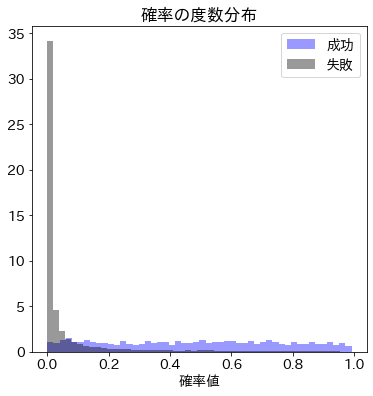

In [16]:
# 確率の度数分布の Graph

# y=0 の化率値取得
y_proba0 = algorithm.predict_proba(x_test)[:, 1]

# y_test=0 と y_test=1 で Data 分割
y0 = y_proba0[y_test == 0]
y1 = y_proba0[y_test == 1]

# 散布図描画
plt.figure(figsize=(6, 6))
plt.title('確率の度数分布')
sns.distplot(y1, kde=False, norm_hist=True, bins=50, color='b', label='成功')
sns.distplot(y0, kde=False, norm_hist=True, bins=50, color='k', label='失敗')
plt.xlabel('確率値')
plt.legend()
plt.show()

Default 0.5 の閾値をもう少し左に移動させてもそれほど成功率は悪くならず、切り捨てられる成功 Case が減らせそう。
上記を行なうためには、閾値を Parameters にした形で予測する必要がある。

In [17]:
# 閾値を変更した場合の予測関数の定義
def pred(algorithm, x, thres):
    # 確率分布の取得（行列）
    y_proba = algorithm.predict_proba(x)

    # 予測結果１の確率値
    y_proba1 = y_proba[:, 1]

    # 予測結果１の確率 > 閾値
    y_pred = (y_proba1 > thres).astype(int)
    return y_pred

In [21]:
# 閾値を 0.05 刻みに変化させて、適合率、再現率、Ｆ値を計算する
thres_list = np.arange(0.5, 0, -0.05)

for thres in thres_list:
    y_pred = pred(algorithm, x_test, thres)
    pred_sum = y_pred.sum()
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    print(f'閾値: {thres:.2f} 陽性予測: {pred_sum} 適合率: {precision:.4f} 再現率: {recall:.4f} Ｆ値: {fscore:.4f}')

閾値: 0.50 陽性予測: 1612 適合率: 0.6290 再現率: 0.4792 Ｆ値: 0.5440
閾値: 0.45 陽性予測: 1839 適合率: 0.6117 再現率: 0.5317 Ｆ値: 0.5689
閾値: 0.40 陽性予測: 2041 適合率: 0.6022 再現率: 0.5808 Ｆ値: 0.5913
閾値: 0.35 陽性予測: 2304 適合率: 0.5820 再現率: 0.6337 Ｆ値: 0.6068
閾値: 0.30 陽性予測: 2544 適合率: 0.5688 再現率: 0.6838 Ｆ値: 0.6210
閾値: 0.25 陽性予測: 2831 適合率: 0.5440 再現率: 0.7278 Ｆ値: 0.6226
閾値: 0.20 陽性予測: 3184 適合率: 0.5135 再現率: 0.7727 Ｆ値: 0.6170
閾値: 0.15 陽性予測: 3616 適合率: 0.4806 再現率: 0.8214 Ｆ値: 0.6064
閾値: 0.10 陽性予測: 4277 適合率: 0.4361 再現率: 0.8814 Ｆ値: 0.5835
閾値: 0.05 陽性予測: 5519 適合率: 0.3629 再現率: 0.9466 Ｆ値: 0.5247


業務観点での関心事である陽性（この場合成功）の値から見た
- 適合率
- 再現率
には Trade-off の関係がある。
２つの値の Balance ちょうどよい地点を見る目安としてＦ値を使用する。
今回は、この考えに沿ってＦ値が最適になっている

**閾値 0.25**

とした結果を Model の最終出力とする。

閾値 0.25 で混合行列などを表示してみる。

In [22]:
# Ｆ値を最大にする閾値は、0.25
y_final = pred(algorithm, x_test, 0.25)

# 混合行列を出力
df_matrix2 = make_cm(confusion_matrix(y_test, y_final), ['失敗', '成功'])
display(df_matrix2)

# 適合率、再現率、f1 値を計算
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_final, average='binary')
print(f'適合率: {precision:.4f} 再現率: {recall:.4f} Ｆ値: {fscore:.4f}')

予測結果      
               失敗    成功
正解 Data 失敗  14678  1291
        成功    576  1540

適合率: 0.5440 再現率: 0.7278 Ｆ値: 0.6226


前回の分析との対比

| 前回          | 今回          |
|-------------|-------------|
| 適合率: 0.6290 | 適合率: 0.5440 |
| 再現率: 0.4792 | 再現率: 0.7278 |

成約できる見込み客の取りこぼしが減少
- 再現率が 47.92% から 72.78% に増加

Model が予想を外す率もそこまで低くなっていない
- 適合率が 62.9% から 54.4%

Model そのものを加工しなくても、解釈（閾値）の工夫で業務としてより効果的な結果を出すことが可能なことを確認。